### Wczytanie danych z preprocesingu

In [17]:
import pandas as pd
import numpy as np
from pathlib import Path

data_dir = Path('data/processed')

# Dane do trenowania autoencodera (tylko normalne próbki)
X_train_autoencoder = pd.read_csv(data_dir / 'autoencoder_train_data.csv')

# Dane testowe
X_test = pd.read_csv(data_dir / 'X_test_scaled.csv')
y_test = pd.read_csv(data_dir / 'y_test.csv')

print("Wczytano obrobione zbiory")
print(f"Kształt X_train_autoencoder (tylko normalne): {X_train_autoencoder.shape}")
print(f"Kształt X_test: {X_test.shape}")

Wczytano obrobione zbiory
Kształt X_train_autoencoder (tylko normalne): (1675959, 69)
Kształt X_test: (454746, 69)


### Informacje o danych treningowych
Plik `autoencoder_train_data.csv` zawiera tylko normalne próbki (klasa 0) przygotowane w preprocesingu

In [18]:
print(f"Liczba normalnych próbek treningowych: {len(X_train_autoencoder)}")
print(f"Liczba cech: {X_train_autoencoder.shape[1]}")

Liczba normalnych próbek treningowych: 1675959
Liczba cech: 69


### Budowa modelu Autoencoder

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

input_dim = X_train_autoencoder.shape[1]
encoding_dim = 8  # Rozmiar warstwy ukrytej

# Encoder
encoder_input = layers.Input(shape=(input_dim,))
encoded = layers.Dense(32, activation='relu')(encoder_input)
encoded = layers.Dense(16, activation='relu')(encoded)
encoded = layers.Dense(encoding_dim, activation='relu')(encoded)

# Decoder
decoded = layers.Dense(16, activation='relu')(encoded)
decoded = layers.Dense(32, activation='relu')(decoded)
decoder_output = layers.Dense(input_dim, activation='linear')(decoded)

# Model
autoencoder = keras.Model(encoder_input, decoder_output)
autoencoder.compile(optimizer='adam', loss='mse')

print("Model Autoencoder zbudowany.")
autoencoder.summary()

Model Autoencoder zbudowany.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 69)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         2,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 69)             │         2,277 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,869 (22.93 KB)

 Trainable params: 5,869 (22.93 KB)

 Non-trainable params: 0 (0.00 B)

### Trenowanie autoencodera

In [ ]:
print("Trenowanie modelu Autoencoder...")

history = autoencoder.fit(
    X_train_autoencoder, X_train_autoencoder,
    epochs=5,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

print("\nModel wytrenowany.")

Trenowanie modelu Autoencoder...
Epoch 1/2
41899/41899 ━━━━━━━━━━━━━━━━━━━━ 77s 2ms/step - loss: 5.3225e-04 - val_loss: 2.0980e-04
Epoch 2/2
41899/41899 ━━━━━━━━━━━━━━━━━━━━ 72s 2ms/step - loss: 1.6168e-04 - val_loss: 1.3339e-04

Model wytrenowany.


### Wizualizacja procesu uczenia

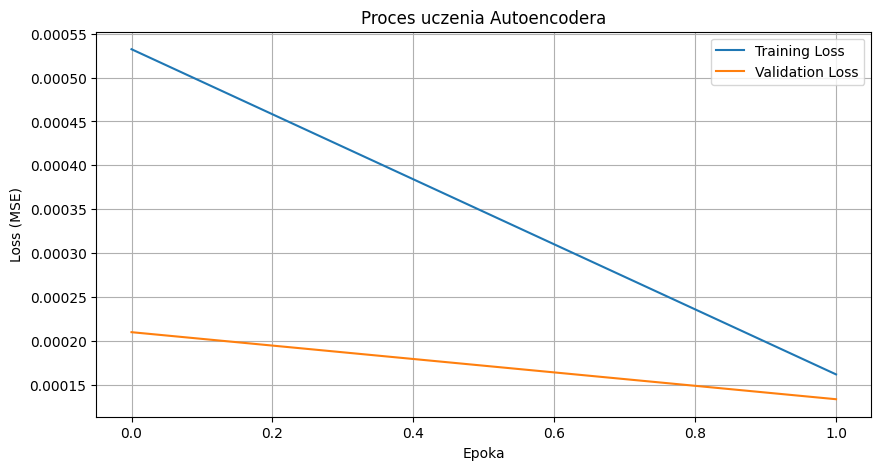

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoka')
plt.ylabel('Loss (MSE)')
plt.title('Proces uczenia Autoencodera')
plt.legend()
plt.grid(True)
plt.show()

### Obliczanie błędu rekonstrukcji

In [22]:
# Rekonstrukcja danych treningowych (normalnych)
X_train_pred = autoencoder.predict(X_train_autoencoder)
train_reconstruction_error = np.mean(np.abs(X_train_autoencoder - X_train_pred), axis=1)

# Rekonstrukcja danych testowych
X_test_pred = autoencoder.predict(X_test)
test_reconstruction_error = np.mean(np.abs(X_test - X_test_pred), axis=1)

print(f"Średni błąd rekonstrukcji (trening): {train_reconstruction_error.mean():.4f}")
print(f"Średni błąd rekonstrukcji (test): {test_reconstruction_error.mean():.4f}")

52374/52374 ━━━━━━━━━━━━━━━━━━━━ 41s 778us/step
14211/14211 ━━━━━━━━━━━━━━━━━━━━ 12s 819us/step
Średni błąd rekonstrukcji (trening): 0.0045
Średni błąd rekonstrukcji (test): 0.0096


### Wyznaczanie progu decyzyjnego

Próg decyzyjny: 0.0265


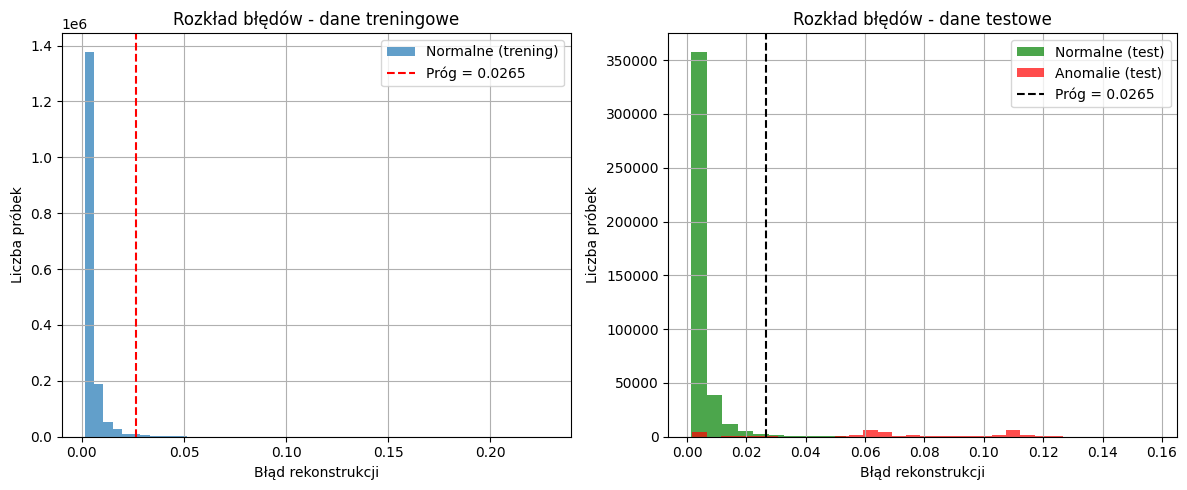

In [36]:
# Próg jako percentyl błędu rekonstrukcji na danych treningowych
threshold = np.percentile(train_reconstruction_error, 99)
print(f"Próg decyzyjny: {threshold:.4f}")

# Wizualizacja rozkładu błędów
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(train_reconstruction_error, bins=50, alpha=0.7, label='Normalne (trening)')
plt.axvline(threshold, color='r', linestyle='--', label=f'Próg = {threshold:.4f}')
plt.xlabel('Błąd rekonstrukcji')
plt.ylabel('Liczba próbek')
plt.title('Rozkład błędów - dane treningowe')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
normal_errors = test_reconstruction_error[y_test.values.ravel() == 0]
anomaly_errors = test_reconstruction_error[y_test.values.ravel() == 1]
plt.hist(normal_errors, bins=30, alpha=0.7, label='Normalne (test)', color='green')
plt.hist(anomaly_errors, bins=30, alpha=0.7, label='Anomalie (test)', color='red')
plt.axvline(threshold, color='black', linestyle='--', label=f'Próg = {threshold:.4f}')
plt.xlabel('Błąd rekonstrukcji')
plt.ylabel('Liczba próbek')
plt.title('Rozkład błędów - dane testowe')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Ocena modelu i macierz pomyłek

⭐ Wynik F1-Macro: 0.9149
---

Raport klasyfikacji:
              precision    recall  f1-score   support

    Normalne       0.98      0.99      0.99    418991
    Anomalie       0.87      0.81      0.84     35755

    accuracy                           0.98    454746
   macro avg       0.93      0.90      0.91    454746
weighted avg       0.98      0.98      0.98    454746

---

Macierz Pomyłek (Confusion Matrix):
 [[414762   4229]
 [  6636  29119]]


<Figure size 800x600 with 0 Axes>

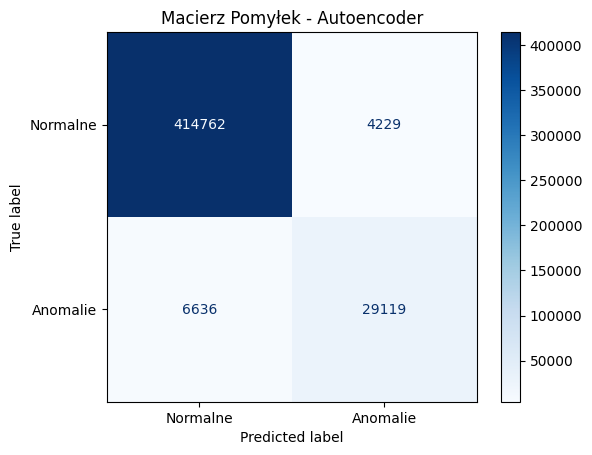

In [37]:
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

# Predykcja: błąd > próg = anomalia (1), błąd <= próg = normalne (0)
y_pred = (test_reconstruction_error > threshold).astype(int)

f1_macro = f1_score(y_test, y_pred, average='macro')
print(f"⭐ Wynik F1-Macro: {f1_macro:.4f}")
print("---\n")

print("Raport klasyfikacji:")
print(classification_report(y_test, y_pred, target_names=['Normalne', 'Anomalie']))
print("---\n")

# Macierz pomyłek
cm = confusion_matrix(y_test, y_pred)
class_labels = [0, 1]

print("Macierz Pomyłek (Confusion Matrix):\n", cm)

# Wizualizacja macierzy pomyłek
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normalne', 'Anomalie'])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Macierz Pomyłek - Autoencoder')
plt.show()